In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc

2024-04-09 21:02:48.710999: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 21:02:48.781999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

# Check GPUs available
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs Available: {gpus}")

# Check if TensorFlow is currently executing eagerly (which means operations are executed as they are defined and is the default mode in TF 2.x)
print(f"Eager execution: {tf.executing_eagerly()}")

# If you have GPUs listed and eager execution is enabled, then operations should automatically run on the GPU if possible.
# To test if TensorFlow will place tensors and operations on the GPU by default, you can create a simple operation and see where it is placed:
if gpus:
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        print(a.device)
else:
    print("No GPU found!")

GPUs Available: []
Eager execution: True
No GPU found!


In [2]:
# This is the list that will hold all of the data (data22 and MC)

datasets = []
pass_HLT = []
tags = ['data', 'HHbbttHadHad', 'ZZ4lep', 'Ztautau', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']

In [3]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-04-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 4)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

In [5]:
# Indices of events that pass the L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

In [11]:
# Determine what factor to scale the weights
num_HLT = np.sum(EB_weights[pass_L1_idxs])
num_zb = np.sum(EB_weights[~pass_L1_idxs])

print(f'(weighted) number of HLT events: {num_HLT}')
print(f'(weighted) number of zerobias events: {num_zb}')

f = (0.2 * num_HLT)/(0.8 * num_zb) # Scaling factor on zb weights such that zb events are 0.2 of training data
print(f'zerobias scaling factor: {f}')

(weighted) number of HLT events: 157337741.5326
(weighted) number of zerobias events: 95436332543.497
zerobias scaling factor: 0.00041215367706237617


In [12]:
# Concatenate HLT data
HLT_data = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)

# Scale the weights of the zerobias data
pass_L1_idxs = (pass_L1_unprescaled == 1) # Indices of events that passed L1
weights = np.copy(EB_weights)
weights[~pass_L1_idxs] *= f

# Remove E and append data to datasets list
datasets.append(HLT_data[:, :, [0, 2, 3]])
pass_HLT.append(pass_HLT_unprescaled)

In [13]:
# Read MC data. Remove E.

filenames = ['HHbbttHadHad.h5', 
             'ZZ4lep.h5', 
             'Ztautau.h5', 
             'jjJZ4.h5', 
             'jjJZ2.h5', 
             'qqa.h5', 
             'HNL7p5_ctau1_eemu.h5',
             'Zprime2EJs.h5',
             'HAHMggfZdZd2l2nu.h5']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename, 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets.append(combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]])
        pass_HLT.append(pass_HLT_unprescaled[0:min(len(combined_data), 100000)])

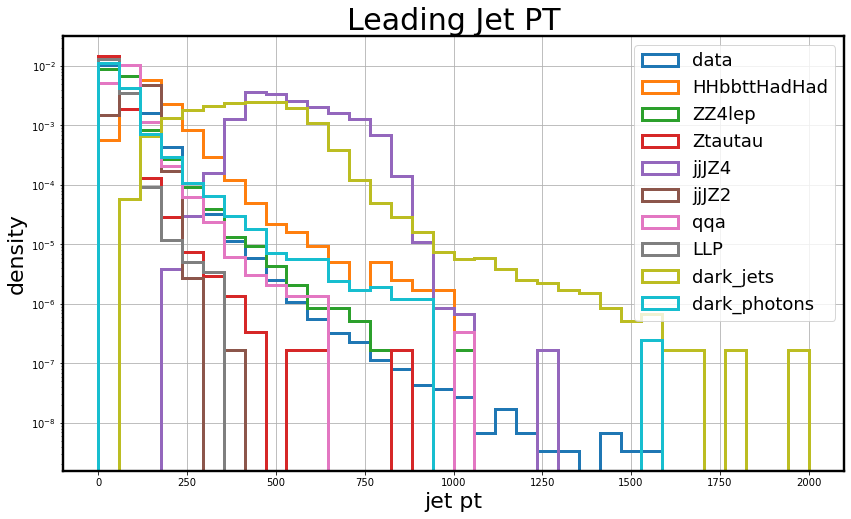

In [14]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for i, tag in enumerate(tags):
    pt = datasets[i][:, 0, 0]
    nonzero_pt = pt[pt > 0]

    if i==0:
        nonzero_weights = weights[pt > 0]
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)
    else:
        plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [15]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for i, data in enumerate(datasets):

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

In [16]:
"""Normalize pt """
for i, data in enumerate(datasets):
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [17]:
for i, dataset in enumerate(datasets):
    print(f'{tags[i]}: {dataset.shape}')

data: (997315, 20, 3)
HHbbttHadHad: (20000, 20, 3)
ZZ4lep: (100000, 20, 3)
Ztautau: (100000, 20, 3)
jjJZ4: (100000, 20, 3)
jjJZ2: (100000, 20, 3)
qqa: (50000, 20, 3)
LLP: (10000, 20, 3)
dark_jets: (100000, 20, 3)
dark_photons: (70000, 20, 3)


In [18]:
# Flatten ndarrays for use in DNN

for i, data in enumerate(datasets):
    datasets[i] = np.reshape(data, newshape=(-1, 60))

for i, data in enumerate(datasets):
    print(f'{tags[i]}: {data.shape}')

data: (997315, 60)
HHbbttHadHad: (20000, 60)
ZZ4lep: (100000, 60)
Ztautau: (100000, 60)
jjJZ4: (100000, 60)
jjJZ2: (100000, 60)
qqa: (50000, 60)
LLP: (10000, 60)
dark_jets: (100000, 60)
dark_photons: (70000, 60)


In [19]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

In [21]:
# Make train, test, val splits

# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

X_train, X_, weights_train, weights_, pass_HLT_train, pass_HLT_ = train_test_split(datasets[0], weights, pass_HLT[0], train_size=0.5)
X_val, X_, weights_val, weights_, pass_HLT_val, pass_HLT_ = train_test_split(X_, weights_, pass_HLT_, train_size=0.2) # 0.1 of original data size
X_test_1, X_test_2, weights_test_1, weights_test_2, pass_HLT_test_1, pass_HLT_test_2 = train_test_split(X_, weights_, pass_HLT_, train_size=0.5)

print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test_1.shape}')
print(f'X_test: {X_test_2.shape}')

X_train: (498657, 60)
X_val: (99731, 60)
X_test: (199463, 60)
X_test: (199464, 60)


In [38]:
# Initialize model
INPUT_DIM = X_train.shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3
DNN_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
DNN_AE.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                1952      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 3)                 27        
                                                                 
 dense_9 (Dense)             (None, 8)                 32        
                                                                 
 dense_10 (Dense)            (None, 32)                288       
                                                                 
 dense_11 (Dense)            (None, 60)                1980

In [39]:
DNN_AE.compile(optimizer='adam', loss=loss_fn)

In [40]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 8
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [41]:
NUM_EPOCHS = 150
BATCH_SIZE = 1024

In [42]:
history = DNN_AE.fit(x=X_train, y=X_train, validation_data=(X_val, X_val), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights_train)

Epoch 1/150
487/487 [==============================] - 4s 5ms/step - loss: 198.9199 - val_loss: 0.9632 - lr: 0.0010
Epoch 2/150
487/487 [==============================] - 2s 5ms/step - loss: 188.6351 - val_loss: 0.9455 - lr: 0.0010
Epoch 3/150
487/487 [==============================] - 2s 4ms/step - loss: 183.4129 - val_loss: 0.9160 - lr: 0.0010
Epoch 4/150
487/487 [==============================] - 2s 5ms/step - loss: 178.1294 - val_loss: 0.8929 - lr: 0.0010
Epoch 5/150
487/487 [==============================] - 2s 4ms/step - loss: 174.5037 - val_loss: 0.8802 - lr: 0.0010
Epoch 6/150
487/487 [==============================] - 2s 4ms/step - loss: 172.5905 - val_loss: 0.8724 - lr: 0.0010
Epoch 7/150
487/487 [==============================] - 2s 4ms/step - loss: 171.4242 - val_loss: 0.8672 - lr: 0.0010
Epoch 8/150
487/487 [==============================] - 2s 4ms/step - loss: 170.4505 - val_loss: 0.8634 - lr: 0.0010
Epoch 9/150
487/487 [==============================] - 2s 5ms/step - los

In [43]:
DNN_AE.save_weights('./trained_models/EB_zb.keras')

In [ ]:
DNN_AE.load_weights('./trained_models/EB_zb.keras')

In [44]:
# Pass the test split and signal datsets through the model

predictions = []
y_true = []


predictions.append(DNN_AE.predict(X_test_1))
y_true.append(X_test_1)
predictions.append(DNN_AE.predict(X_test_2))
y_true.append(X_test_2)

for i, data in enumerate(datasets):
    if i==0: continue

    y_true.append(data)
    predictions.append(DNN_AE.predict(data))

2188/2188 [==============================] - 3s 1ms/step


In [45]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [46]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [47]:
# Calculate the AD scores on test split and signals

total_loss = []

for i, prediction in enumerate(predictions):
    total_loss.append(AD_score(y_true[i], prediction))

<Figure size 1296x720 with 0 Axes>

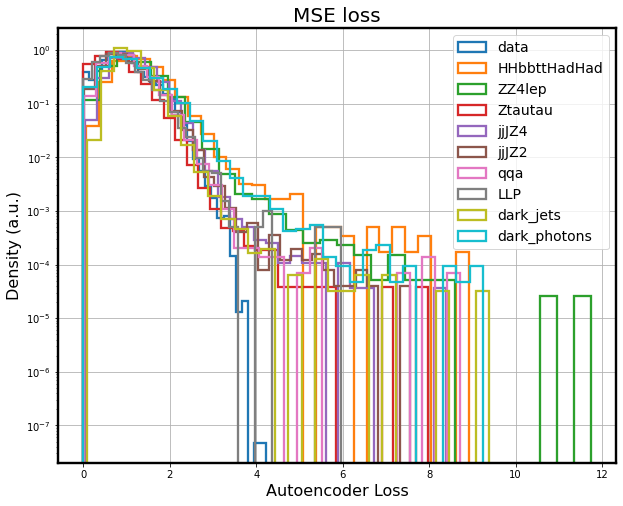

In [48]:
# Plot a histogram of the AD scores

plt.figure(figsize=(18, 10))
plt.rcParams['axes.linewidth'] = 2.4

#bins = np.linspace(0, 50000, num=30)
bins=30
plt.figure(figsize=(10,8))
for i, tag in enumerate(tags):
    if i==0:
        plt.hist(total_loss[i+1], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3, weights=weights_test_2)
    else:
        plt.hist(total_loss[i+1], bins=bins, label=tag, density = True, histtype='step', fill=False, linewidth=2.3)


plt.yscale('log')
plt.xlabel("Autoencoder Loss", fontsize=16)
plt.ylabel("Density (a.u.)", fontsize=16)
plt.title('MSE loss', fontsize=20)
plt.legend(loc='best', fontsize=14)
plt.grid()
#plt.xlim(0, 0.2 * pow(10, 6))
plt.show()

data: TPR at FPR of 10^-4 is 0.0001 with threshold 3.3087
threshold FPR: 0.00010720103837342444
HHbbttHadHad: TPR at FPR of 10^-4 is 0.00620 with threshold 3.3087
ZZ4lep: TPR at FPR of 10^-4 is 0.00329 with threshold 3.3087
Ztautau: TPR at FPR of 10^-4 is 0.00041 with threshold 3.3087
jjJZ4: TPR at FPR of 10^-4 is 0.00075 with threshold 3.3087
jjJZ2: TPR at FPR of 10^-4 is 0.00084 with threshold 3.3087
qqa: TPR at FPR of 10^-4 is 0.00050 with threshold 3.3087
LLP: TPR at FPR of 10^-4 is 0.00070 with threshold 3.3087
dark_jets: TPR at FPR of 10^-4 is 0.00052 with threshold 3.3087
dark_photons: TPR at FPR of 10^-4 is 0.00409 with threshold 3.3087


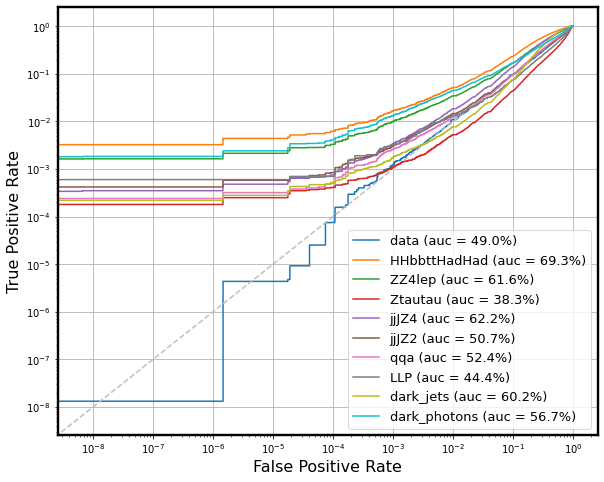

In [49]:
# Plot the ROC curves

target_background = np.zeros(total_loss[0].shape[0])

plt.figure(figsize=(8.5,6.8))

for i, label in enumerate(tags):
    # Combine true labels, anomaly=1 and background=0
    trueVal = np.concatenate((np.ones(total_loss[i+1].shape[0]), target_background))
    
    # Combine predictions from current dataset and background
    predVal_loss = np.concatenate((total_loss[i+1], total_loss[0]))
    
    # Include weights for the EB data and assign no weight (or equal weight) for the other dataset
    if i == 0:  # For the EB data
        sample_weights = np.concatenate((weights_test_2, weights_test_1))
    else:  # For the MC datasets, assume equal weight
        sample_weights = np.concatenate((np.ones(total_loss[i+1].shape[0]), weights_test_1))

    # Calculate ROC curve and AUC, including weights
    fpr_loss, tpr_loss, threshold_loss = roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, "-", label='%s (auc = %.1f%%)' % (label, auc_loss*100.), linewidth=1.5)

    # Find index where FPR is closest to 10^-4 and print TPR and threshold for that index
    if i ==0: 
        target_fpr = 10**-4
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.4f} with threshold {threshold_loss[idx]:.4f}")
        print(f"threshold FPR: {fpr_loss[idx]}")
        threshold = threshold_loss[idx]
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        #plt.axvline(fpr_loss[idx], color='red', linestyle='dashed', linewidth=2, label=fpr_loss[idx])  # Threshold value
    else:
        idx = np.argmin(np.abs(fpr_loss - target_fpr))
        print(f"{label}: TPR at FPR of 10^-4 is {tpr_loss[idx]:.5f} with threshold {threshold_loss[idx]:.4f}")

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("True Positive Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements

#plt.title("ROC Curve", fontsize)
plt.show()

In [134]:
"""Print the HLT overlap (the percentage of events we found as anomalous that
are already being triggered by the HLT)
and Inverse Overlap (the additional amount of signal we trigger on compared to 
just the HLT)"""

for i, tag in enumerate(tags):
    anomaly_idxs = (total_loss[i] > threshold)
    HLT_overlap = 0
    inverse_overlap=0

    if i ==0:
        for a, h in zip(anomaly_idxs, pass_HLT_test):
            if a==1 and h==1:
                HLT_overlap += 1
                
            if a==1 or h==1:
                inverse_overlap += 1
            
        HLT_overlap /= np.sum(anomaly_idxs)
        inverse_overlap /= np.sum(pass_HLT_test)
    else:
        for a, h in zip(anomaly_idxs, pass_HLT[i]):
            if a==1 and h==1:
                HLT_overlap += 1
            
            if a==1 or h==1:
                inverse_overlap += 1
                
        HLT_overlap /= np.sum(anomaly_idxs)
        inverse_overlap /= np.sum(pass_HLT[i])

    print(f'-----\n{tag}:')
    print(f'HLT overlap: {HLT_overlap}')
    print(f'inverse overlap: {inverse_overlap}')
    print(f'percentage of events that passed some HLT trigger: {np.sum(pass_HLT_test) / len(pass_HLT_test)}')
    print(f'percentage of events that we tagged as anomalous: {np.sum(anomaly_idxs) / len(anomaly_idxs)}')
    print(f'number of events that we tagged as anomalous: {np.sum(anomaly_idxs)}')

-----
data:
HLT overlap: 0.0
inverse overlap: 1.0114665057332528
percentage of events that passed some HLT trigger: 0.008307305114231712
percentage of events that we tagged as anomalous: 9.525576172021878e-05
number of events that we tagged as anomalous: 19
-----
HHbbttHadHad:
HLT overlap: 0.5942028985507246
inverse overlap: 1.0025751862411478
percentage of events that passed some HLT trigger: 0.008307305114231712
percentage of events that we tagged as anomalous: 0.00345
number of events that we tagged as anomalous: 69
-----
ZZ4lep:
HLT overlap: 0.9020618556701031
inverse overlap: 1.0002179398944713
percentage of events that passed some HLT trigger: 0.008307305114231712
percentage of events that we tagged as anomalous: 0.00194
number of events that we tagged as anomalous: 194
-----
Ztautau:
HLT overlap: 0.10526315789473684
inverse overlap: 1.0025537028691602
percentage of events that passed some HLT trigger: 0.008307305114231712
percentage of events that we tagged as anomalous: 0.00019

In [34]:
# As a sanity check, calculate the HLT rate from our list of triggers

HLT_rate = np.sum(weights * pass_HLT[0]) / np.sum(weights)
print(f'HLT rate: {HLT_rate * 100000}')
print(f'HLT acceptance: {HLT_rate}')
print(f'HLT rejection: {1/HLT_rate}')

HLT rate: 6.09708956022737
HLT acceptance: 6.09708956022737e-05
HLT rejection: 16401.26801684554


In [ ]:
# Calculate the additional rate added by our trigger

HLT_numerator = 0
HLT_denominator = 0
HLT_AD_numerator = 0
HLT_AD_denominator = 0


anomaly_idxs = (total_loss[0] > threshold)
HLT_numerator += np.sum(weights_test * pass_HLT_test)
HLT_denominator += np.sum(weights_test)

HLT_AD_numerator += np.sum(weights_test * np.bitwise_or(anomaly_idxs, pass_HLT_test))
HLT_AD_denominator += np.sum(weights_test)



HLT_acceptance = HLT_numerator / HLT_denominator
HLT_AD_acceptance = HLT_AD_numerator / HLT_AD_denominator

# Multiply by 100,000 since there are 100,000Hz going INTO the HLT
print(f'HLT rate: {HLT_acceptance * 100000}')
print(f'HLT + AD rate: {HLT_AD_acceptance * 100000}')
print(f'rate added by AD: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

In [ ]:
HLT_numerator = 0
HLT_denominator = 0
HLT_AD_numerator = 0
HLT_AD_denominator = 0


anomaly_idxs = (total_loss[0] > threshold)
HLT_numerator += np.sum(weights_test * pass_HLT_test)
HLT_denominator += np.sum(weights_test)

HLT_AD_numerator += np.sum(weights_test * np.bitwise_or(anomaly_idxs, pass_HLT_test))
HLT_AD_denominator += np.sum(weights_test)



HLT_acceptance = HLT_numerator / HLT_denominator
HLT_AD_acceptance = HLT_AD_numerator / HLT_AD_denominator

# Multiply by 100,000 since there are 100,000Hz going INTO the HLT
print(f'HLT rate: {HLT_acceptance * 100000}')
print(f'HLT + AD rate: {HLT_AD_acceptance * 100000}')
print(f'rate added by AD: {(HLT_AD_acceptance - HLT_acceptance) * 100000}')

In [ ]:
# Calculate the additional rate added by the AD trigger for each FPR

rates = []
overlaps = []
for i, fpr in enumerate(fpr_loss):
    threshold = threshold_loss[i]

    # Calcaulte rates
    # ----------------------------------------
    HLT_numerator = 0
    HLT_denominator = 0
    HLT_AD_numerator = 0
    HLT_AD_denominator = 0
    
    
    anomaly_idxs = (total_loss[0] > threshold)
    HLT_numerator += np.sum(weights_test * pass_HLT_test)
    HLT_denominator += np.sum(weights_test)
    
    HLT_AD_numerator += np.sum(weights_test * np.bitwise_or(anomaly_idxs, pass_HLT_test))
    HLT_AD_denominator += np.sum(weights_test)
    
    
    
    HLT_acceptance = HLT_numerator / HLT_denominator
    HLT_AD_acceptance = HLT_AD_numerator / HLT_AD_denominator
    
    # Multiply by 100,000 since there are 100,000Hz going INTO the HLT
    rates.append((HLT_AD_acceptance - HLT_acceptance) * 100000)
    # ---------------------------------------------------------

    # Calculate HLT Overlap (this takes too long to run, maybe there's a better way to do this)
    # --------------------------------------------
    # anomaly_idxs = (total_loss[0] > threshold)
    # HLT_overlap = 0
    # inverse_overlap=0

    
    # for a, h in zip(anomaly_idxs, pass_HLT_test):
    #     if a==1 and h==1:
    #         HLT_overlap += 1
        
    # HLT_overlap /= np.sum(anomaly_idxs)
    # overlaps.append(HLT_overlap)

In [ ]:
# Plot the additional rate vs FPR

plt.figure(figsize=(8.5,6.8))

plt.plot(fpr_loss, rates, color='navy', linewidth=2.5)

# Set log scale for x and y axis
plt.semilogx()
plt.semilogy()

# Plot aesthetics and layout
plt.ylabel("Additional Rate", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=16)
#plt.legend(loc='lower right', fontsize=13)
plt.grid(True)
plt.tight_layout()

# Additional plot elements
#plt.title("ROC Curve", fontsize)
plt.show()